In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

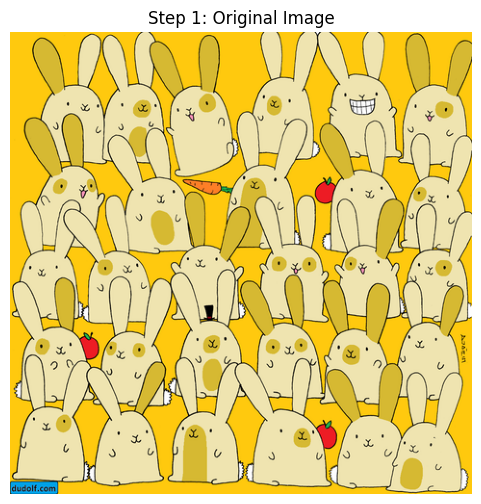

In [ ]:
# Step 1: Load and display the original image
image = cv2.imread("/content/rabbit2.png")
plt.figure(figsize=(6, 6))
plt.imshow(image[...,::-1])  # Convert BGR to RGB for display
plt.title("Step 1: Original Image")
plt.axis("off")
plt.show()

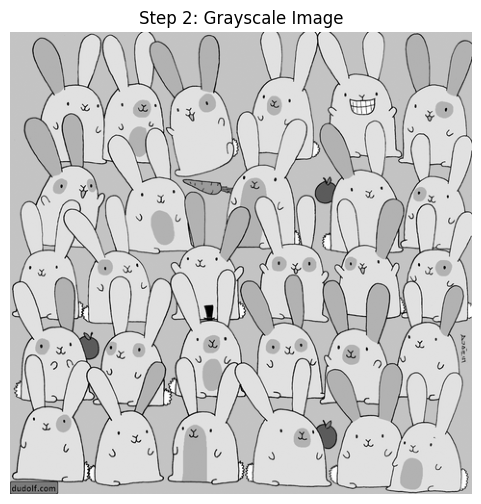

In [ ]:
# Step 2: Convert to grayscale and display
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(6, 6))
plt.imshow(gray, cmap="gray")
plt.title("Step 2: Grayscale Image")
plt.axis("off")
plt.show()

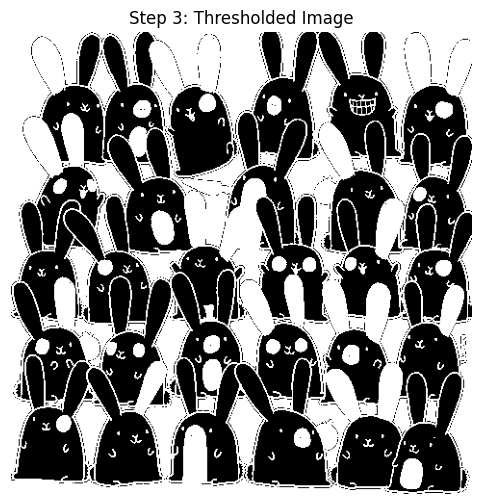

In [ ]:
# Step 3: Apply thresholding and display
# Using THRESH_BINARY_INV since rabbits are darker than the yellow background
_, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)
plt.figure(figsize=(6, 6))
plt.imshow(thresh, cmap="gray")
plt.title("Step 3: Thresholded Image")
plt.axis("off")
plt.show()

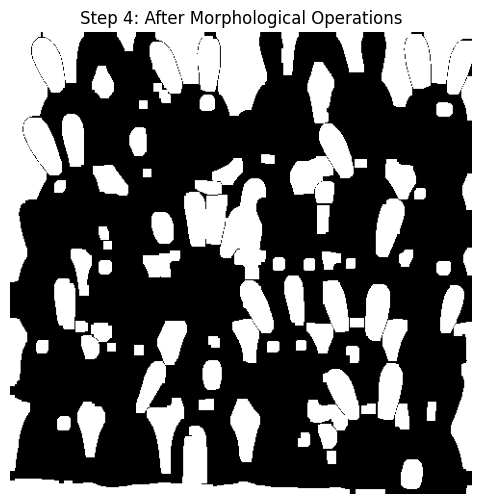

In [ ]:
# Step 4: Apply morphological operations to clean up and display
kernel = np.ones((5, 5), np.uint8)
cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
plt.figure(figsize=(6, 6))
plt.imshow(cleaned, cmap="gray")
plt.title("Step 4: After Morphological Operations")
plt.axis("off")
plt.show()

In [ ]:
# Step 5: Find contours, draw them, and display the final result
contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_area = 500  # Filter small contours (adjust based on image resolution)
rabbit_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
rabbit_count = len(rabbit_contours)

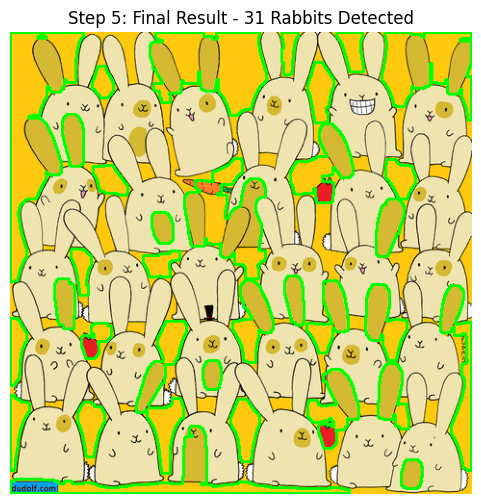

In [ ]:
# Draw contours on the original image
output_image = image.copy()
cv2.drawContours(output_image, rabbit_contours, -1, (0, 255, 0), 2)  # Green contours
plt.figure(figsize=(6, 6))
plt.imshow(output_image[...,::-1])  # Convert BGR to RGB
plt.title(f"Step 5: Final Result - {rabbit_count} Rabbits Detected")
plt.axis("off")
plt.show()

In [ ]:
# Print the final count
print(f"Number of rabbits detected: {rabbit_count}")

Number of rabbits detected: 31


Improve the result

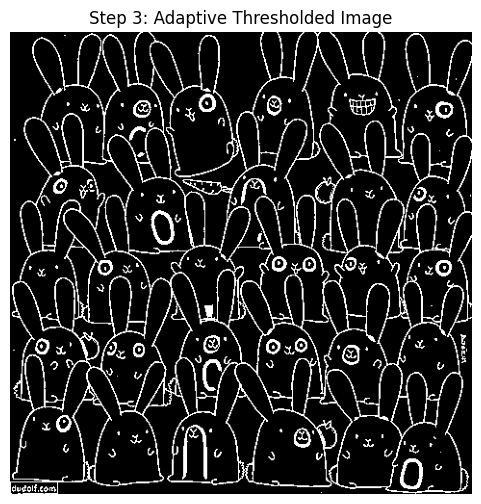

In [ ]:
# Step 3: Apply adaptive thresholding and display
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 11, 2)
plt.figure(figsize=(6, 6))
plt.imshow(thresh, cmap="gray")
plt.title("Step 3: Adaptive Thresholded Image")
plt.axis("off")
plt.show()

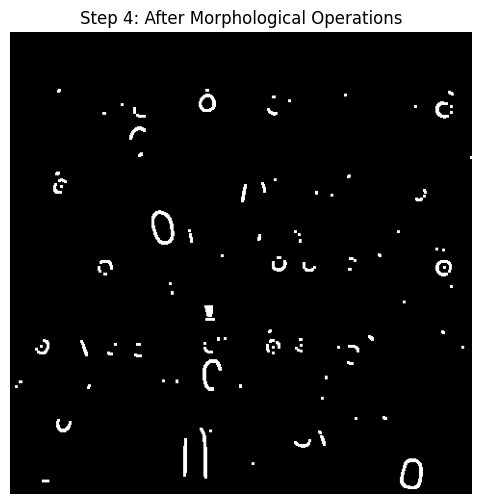

In [ ]:
# Step 4: Apply morphological operations to clean up and display
# Reduced kernel size and iterations to avoid over-eroding
kernel = np.ones((3, 3), np.uint8)  # Smaller kernel
cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)  # Fewer iterations
# Removed the additional dilation step to prevent over-processing
plt.figure(figsize=(6, 6))
plt.imshow(cleaned, cmap="gray")
plt.title("Step 4: After Morphological Operations")
plt.axis("off")
plt.show()

In [ ]:
# Step 5: Find contours, filter them, and display the final result
contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Contour filtering
min_area = 800  # Adjusted to filter small noise
max_area = 10000  # To exclude overly large contours
rabbit_contours = []
for cnt in contours:
    area = cv2.contourArea(cnt)
    if min_area < area < max_area:
        # Aspect ratio filter (rabbits are generally taller than wide)
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = float(h) / w
        if 0.5 < aspect_ratio < 2.0:
            rabbit_contours.append(cnt)

rabbit_count = len(rabbit_contours)

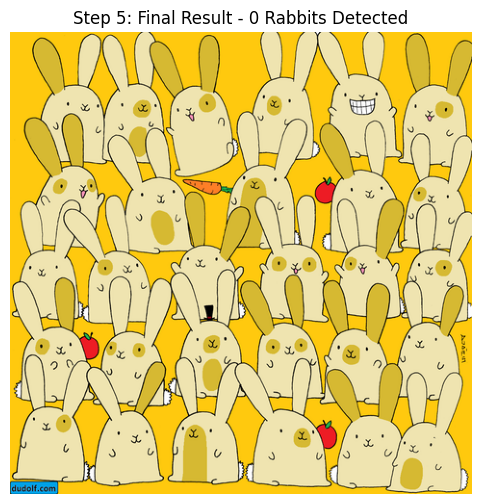

In [ ]:
# Draw contours on the original image
output_image = image.copy()
cv2.drawContours(output_image, rabbit_contours, -1, (0, 255, 0), 2)  # Green contours
plt.figure(figsize=(6, 6))
plt.imshow(output_image[...,::-1])  # Convert BGR to RGB
plt.title(f"Step 5: Final Result - {rabbit_count} Rabbits Detected")
plt.axis("off")
plt.show()

Another way

In [2]:
def rotate_image(image, angle, center=None, scale=1.0):
    """
    Xoay ảnh với một góc nhất định.

    Parameters:
    - image: Ảnh đầu vào.
    - angle: Góc xoay (đơn vị độ).
    - center: Điểm xoay (nếu None, sử dụng giữa ảnh).
    - scale: Tỷ lệ phóng to/thu nhỏ (mặc định là 1.0).

    Returns:
    - Ảnh đã xoay.
    """
    # Nếu center là None, đặt center ở giữa ảnh
    if center is None:
        center = (image.shape[1] // 2, image.shape[0] // 2)

    # Tạo ma trận xoay
    M = cv2.getRotationMatrix2D(center, angle, scale)

    # Áp dụng xoay
    rotated_image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

    return rotated_image

In [3]:
def draw(image, locations, w, h, color=(0, 255, 0), thickness=1):
    for pt in zip(*locations[::-1]):
        pt = (int(pt[0]), int(pt[1]))
        cv2.rectangle(image, pt, (pt[0] + w, pt[1] + h), color, thickness)
    return image, len(locations[0])

In [4]:
def template_matching(image, template, down_threshold=0.65, up_threshold=1,
                      resize_temp=False, min_scale_x=0.8, max_scale_x=1.2, min_scale_y=0.8, max_scale_y=1.2, num_scales=50,
                      rotate_temp=False, min_angle=-90, max_angle=90, num_angles=50,
                      maskH=None, maskW=None):
    """
    Performs template matching to find regions in the image that match the template.
    Supports scaling and rotating the template to handle variations in size and orientation.

    Parameters:
    - image: The larger image to search in.
    - template: The smaller image (template) to match.
    - down_threshold, up_threshold: Similarity score thresholds for matching.
    - resize_temp: If True, resize the template to different scales.
    - min_scale_x, max_scale_x, min_scale_y, max_scale_y, num_scales: Parameters for scaling the template.
    - rotate_temp: If True, rotate the template to different angles.
    - min_angle, max_angle, num_angles: Parameters for rotating the template.
    - maskH, maskW: Optional dimensions for masking matched regions.

    Returns:
    - image: Image with matched regions marked (blacked out).
    - locations: Tuple of (y_coords, x_coords) for detected matches.
    """
    # Step 1: Initialize the image and template
    # Ensure the image and template are in the correct format for OpenCV
    image = image
    template = template

    # Step 2: Handle different modes based on resize_temp and rotate_temp
    if resize_temp and not rotate_temp:
        # Mode 1: Resize the template to different scales, but don't rotate
        # Generate scales for x and y axes using a linear range
        scales_x = np.linspace(min_scale_x, max_scale_x, num_scales)
        scales_y = np.linspace(min_scale_y, max_scale_y, num_scales)
        # Initialize empty arrays to store match locations
        locations = [np.empty(0), np.empty(0)]

        # Loop over all combinations of x and y scales
        for fx in scales_x:
            for fy in scales_y:
                # Resize the template to the current scale
                resized_template = cv2.resize(template, None, fx=fx, fy=fy)
                # Apply template matching using the normalized correlation coefficient method
                result = cv2.matchTemplate(image, resized_template, cv2.TM_CCOEFF_NORMED)

                # Find locations where the similarity score is within the threshold range
                loc = np.where((up_threshold >= result) & (result >= down_threshold))
                # Append the new locations to the existing ones
                locations[0] = np.concatenate([locations[0], loc[0]])
                locations[1] = np.concatenate([locations[1], loc[1]])

                # Determine the dimensions for masking (use maskH/W if provided, else use template size)
                if maskH:
                    h, w = maskH, maskW
                else:
                    h, w = resized_template.shape[:2]
                # Draw black rectangles over the matched regions to mask them
                image, _ = draw(image, loc, w, h, color=(0, 0, 0), thickness=-1)

    elif rotate_temp and not resize_temp:
        # Mode 2: Rotate the template to different angles, but don't resize
        # Generate angles using a linear range (reversed for consistency)
        angles = np.linspace(min_angle, max_angle, num_angles)[::-1]
        # Initialize empty arrays to store match locations
        locations = [np.empty(0), np.empty(0)]

        # Loop over all angles
        for angle in angles:
            # Rotate the template to the current angle
            rotated_template = rotate_image(template, angle)
            # Apply template matching
            result = cv2.matchTemplate(image, rotated_template, cv2.TM_CCOEFF_NORMED)

            # Find locations where the similarity score is within the threshold range
            loc = np.where((up_threshold >= result) & (result >= down_threshold))
            # Append the new locations
            locations[0] = np.concatenate([locations[0], loc[0]])
            locations[1] = np.concatenate([locations[1], loc[1]])

            # Determine the dimensions for masking
            if maskH:
                h, w = maskH, maskW
            else:
                h, w = rotated_template.shape[:2]
            # Draw black rectangles over the matched regions
            image, _ = draw(image, loc, w, h, color=(0, 0, 0), thickness=-1)

    elif rotate_temp and resize_temp:
        # Mode 3: Both resize and rotate the template
        # Generate scales and angles
        scales_x = np.linspace(min_scale_x, max_scale_x, num_scales)[::-1]
        scales_y = np.linspace(min_scale_y, max_scale_y, num_scales)[::-1]
        angles = np.linspace(min_angle, max_angle, num_angles)[::-1]
        # Initialize empty arrays to store match locations
        locations = [np.empty(0), np.empty(0)]

        # Loop over all combinations of scales and angles
        for fx in scales_x:
            for fy in scales_y:
                for angle in angles:
                    # Resize the template
                    resized_template = cv2.resize(template, None, fx=fx, fy=fy)
                    # Rotate the resized template
                    rotated_template = rotate_image(resized_template, angle)
                    # Apply template matching
                    result = cv2.matchTemplate(image, rotated_template, cv2.TM_CCOEFF_NORMED)

                    # Find locations where the similarity score is within the threshold range
                    loc = np.where((up_threshold >= result) & (result >= down_threshold))
                    # Append the new locations
                    locations[0] = np.concatenate([locations[0], loc[0]])
                    locations[1] = np.concatenate([locations[1], loc[1]])

                    # Determine the dimensions for masking
                    if maskH:
                        h, w = maskH, maskW
                    else:
                        h, w = rotated_template.shape[:2]
                    # Draw black rectangles over the matched regions
                    image, _ = draw(image, loc, w, h, color=(0, 0, 0), thickness=-1)

    else:
        # Mode 4: No resizing or rotation, just apply template matching directly
        # Apply template matching with the original template
        result = cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
        # Find locations where the similarity score is within the threshold range
        locations = np.where((up_threshold >= result) & (result >= down_threshold))

        # Determine the dimensions for masking
        if maskH:
            h, w = maskH, maskW
        else:
            h, w = template.shape[:2]
        # Draw black rectangles over the matched regions
        image, _ = draw(image, locations, w, h, color=(0, 0, 0), thickness=-1)

    # Step 3: Return the marked image and the locations of matches
    return image, locations

In [5]:
def process_match(image, x, y, w, h, locations, down_threshold=0.65, up_threshold=1,
                  resize_temp=False, min_scale_x=0.8, max_scale_x=1.2, min_scale_y=0.8, max_scale_y=1.2, num_scales=21,
                  rotate_temp=False, min_angle=-20, max_angle=20, num_angles=21,
                  maskH=None, maskW=None, inheritance=True):
    """
    Wrapper function to crop a region from the image, use it as a template, and apply template matching.

    Parameters:
    - image: The larger image to search in.
    - x, y, w, h: Coordinates and dimensions of the region to crop (top-left at (x, y), width w, height h).
    - locations: Tuple of (y_coords, x_coords) for previously detected matches.
    - down_threshold, up_threshold: Similarity score thresholds for matching.
    - resize_temp: If True, resize the template to different scales.
    - min_scale_x, max_scale_x, min_scale_y, max_scale_y, num_scales: Parameters for scaling the template.
    - rotate_temp: If True, rotate the template to different angles.
    - min_angle, max_angle, num_angles: Parameters for rotating the template.
    - maskH, maskW: Optional dimensions for masking matched regions.
    - inheritance: If True, append new locations to the existing ones; if False, return only new locations.

    Returns:
    - image: Image with matched regions marked.
    - locations: Updated or new locations of matches.
    """
    # Step 1: Crop the region of interest (ROI) from the image to use as the template
    # The ROI is defined by the coordinates (x, y) and dimensions (w, h)
    crop_img = image[y:y+h, x:x+w].copy()

    # Step 2: Apply template matching using the cropped region as the template
    # Pass all parameters to control scaling, rotation, and thresholding
    image, loc = template_matching(image, crop_img, down_threshold, up_threshold,
                                   resize_temp, min_scale_x, max_scale_x, min_scale_y, max_scale_y, num_scales,
                                   rotate_temp, min_angle, max_angle, num_angles,
                                   maskH=maskH, maskW=maskW)

    # Step 3: Handle the locations of detected matches
    if inheritance:
        # If inheritance is True, append new locations to the existing ones
        # locations[0] stores y-coordinates, locations[1] stores x-coordinates
        locations[0] = np.concatenate([locations[0], loc[0]])
        locations[1] = np.concatenate([locations[1], loc[1]])
        return image, locations
    else:
        # If inheritance is False, return only the new locations
        return image, loc


Số lượng thỏ: 29


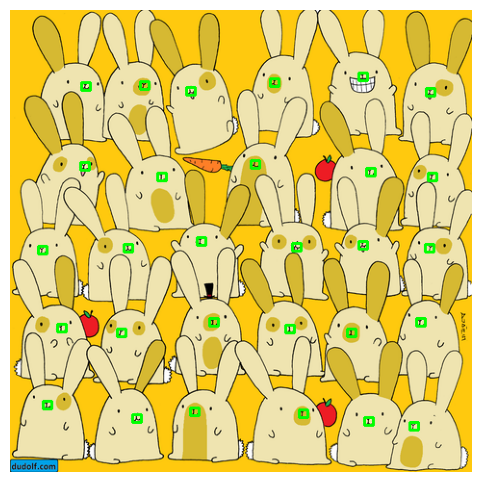

In [ ]:
# rabbit2.png
image = cv2.imread('/content/rabbit2.png')
image_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# """
# Phát hiện cạnh trong ảnh sử dụng Canny Edge Detection.
# - low_threshold: Ngưỡng thấp để phát hiện cạnh yếu.
# - high_threshold: Ngưỡng cao để phát hiện cạnh mạnh.
# """"
image_edges = cv2.Canny(image_grey, 50, 150)

locations = [np.empty(0), np.empty(0)]
w, h = 9, 8

x, y = 422, 320
image_grey, locations = process_match(image_grey, x, y, w, h, locations, down_threshold=0.71, up_threshold=1,
                                      rotate_temp=True, min_angle=-30, max_angle=30, num_angles=51)

x, y = 118, 243
image_grey, locations = process_match(image_grey, x, y, w, h, locations, down_threshold=0.7, up_threshold=1,
                                      rotate_temp=True, min_angle=-30, max_angle=30, num_angles=51)

x, y = 293, 242
image_grey, locations = process_match(image_grey, x, y, w, h, locations, down_threshold=0.7, up_threshold=1,
                                      rotate_temp=True, min_angle=-30, max_angle=30, num_angles=51)

x, y = 286, 327
image_grey, locations = process_match(image_grey, x, y, w, h, locations, down_threshold=0.7, up_threshold=1,
                                      rotate_temp=True, min_angle=-30, max_angle=30, num_angles=51)

x, y = 74, 75
image_grey, locations = process_match(image_grey, x, y, w, h, locations, down_threshold=0.66, up_threshold=1,
                                      rotate_temp=True, min_angle=-30, max_angle=30, num_angles=51)

x, y = 183, 80
w1, h1 = 9, 13
image_grey, locations = process_match(image_grey, x, y, w1, h1, locations, down_threshold=1, up_threshold=1)

x, y = 362, 240
w1, h1 = 9, 12
image_grey, locations = process_match(image_grey, x, y, w1, h1, locations, down_threshold=1, up_threshold=1)

x, y = 431, 243
w1, h1 = 9, 12
image_grey, locations = process_match(image_grey, x, y, w1, h1, locations, down_threshold=1, up_threshold=1)

res_image = image.copy()
res_image, count = draw(res_image, locations, w, h, thickness=2)
print('Số lượng thỏ:', count)

# show image
res_image = cv2.cvtColor(res_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.imshow(res_image)
plt.axis('off')  # Tắt hiển thị trục
plt.show()

Số lượng mèo: 105


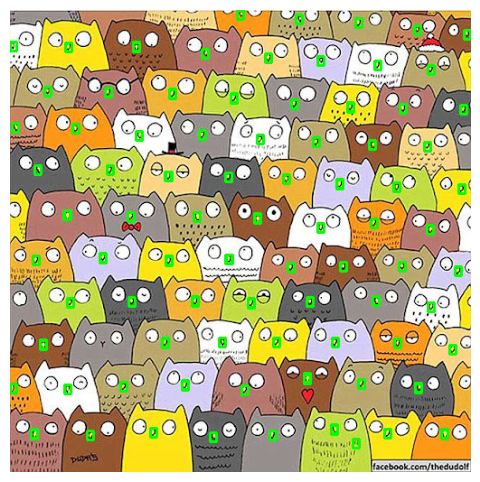

In [ ]:
# cat.jpg
image = cv2.imread('cat.jpg')
image_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_edges = cv2.Canny(image_grey, 50, 150)

locations = [np.empty(0), np.empty(0)]
w, h = 7, 10

x, y = 61, 36
image_grey, locations = process_match(image_grey, x, y, w, h, locations)

x, y = 27, 172
image_grey, locations = process_match(image_grey, x, y, w, h, locations, down_threshold=0.8)

x, y = 325, 403
image_grey, locations = process_match(image_grey, x, y, w, h, locations)

x, y = 203, 224
image_grey, locations = process_match(image_grey, x, y, w, h, locations)

x, y = 212, 43
image_grey, locations = process_match(image_grey, x, y, w, h, locations)

x, y = 340, 51
image_grey, locations = process_match(image_grey, x, y, w, h, locations)

x, y = 0, 414
image_grey, locations = process_match(image_grey, x, y, w, h, locations, down_threshold=0.8)

x, y = 0, 35
image_grey, locations = process_match(image_grey, x, y, w, h, locations, down_threshold=0.8)

res_image = image.copy()
res_image, count = draw(res_image, locations, w, h, thickness=2)
print('Số lượng mèo:', count)


# show image
res_image = cv2.cvtColor(res_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.imshow(res_image)
plt.axis('off')  # Tắt hiển thị trục
plt.show()

Số lượng dôi ủng: 72


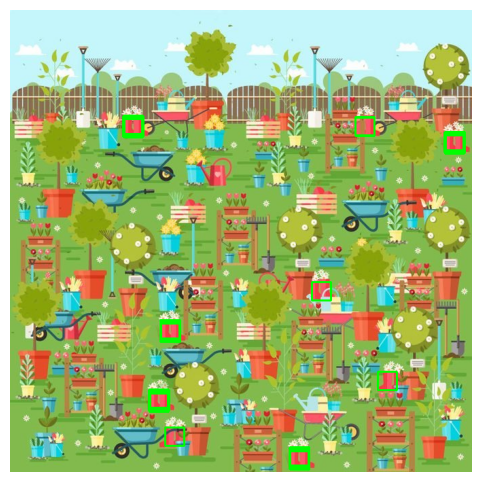

In [90]:
# pair_boot.jpg
image = cv2.imread('/content/pair_boot.jpg')
image_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_edges = cv2.Canny(image_grey, 50, 150)

locations = [np.empty(0), np.empty(0)]
w, h = 28, 27

x, y = 205, 561
image_grey, locations = process_match(image_grey, x, y, w, h, locations, down_threshold=0.54, up_threshold=1)

x, y = 444, 400
image_grey, locations = process_match(image_grey, x, y, w, h, locations, down_threshold=0.9, up_threshold=1)

x, y = 541, 532
image_grey, locations = process_match(image_grey, x, y, w, h, locations, down_threshold=0.9, up_threshold=1)

x, y = 228, 614
image_grey, locations = process_match(image_grey, x, y, w, h, locations, down_threshold=0.9, up_threshold=1)

# Convert locations to a list of (x, y) coordinates
coords = list(zip(*locations[::-1]))
# Remove duplicates by converting to a set and back to a list
locations = list(set(coords))
print('Số lượng dôi ủng:', len(locations))

res_image = image.copy()
for pt in locations:
    pt = (int(pt[0]), int(pt[1]))
    cv2.rectangle(res_image, pt, (pt[0] + w, pt[1] + h), (0, 255, 0), 2)

# show image
res_image = cv2.cvtColor(res_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.imshow(res_image)
plt.axis('off')
plt.show()

Số lượng thỏ: 46


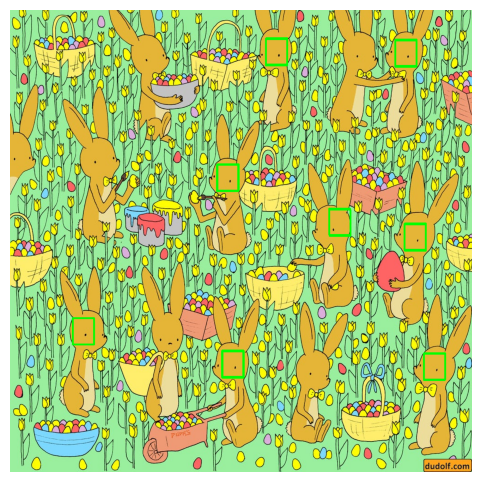

In [8]:
# rabbit.jpeg
image = cv2.imread('/content/rabbit.jpeg')
image_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_edges = cv2.Canny(image_grey, 50, 150)

locations = [np.empty(0), np.empty(0)]
w, h = 46, 57

x, y = 0, 276
image_grey, locations = process_match(image_grey, x, y, w, h, locations, down_threshold=0.5, up_threshold=1)

x, y = 448, 334
image_grey, locations = process_match(image_grey, x, y, w, h, locations, down_threshold=0.6, up_threshold=1)

# Define a filtering function
def keep_coord(coord):
    x, y = coord
    return x > 100  # Example condition: keep coordinates where x > 100

# Apply filter
coords = list(zip(*locations[::-1]))
locations = list(filter(keep_coord, coords))
print('Số lượng thỏ:', len(locations))

res_image = image.copy()
for pt in locations:
    pt = (int(pt[0]), int(pt[1]))
    cv2.rectangle(res_image, pt, (pt[0] + w, pt[1] + h), (0, 255, 0), 2)

# show image
res_image = cv2.cvtColor(res_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.imshow(res_image)
plt.axis('off')
plt.show()

Số lượng thỏ: 14


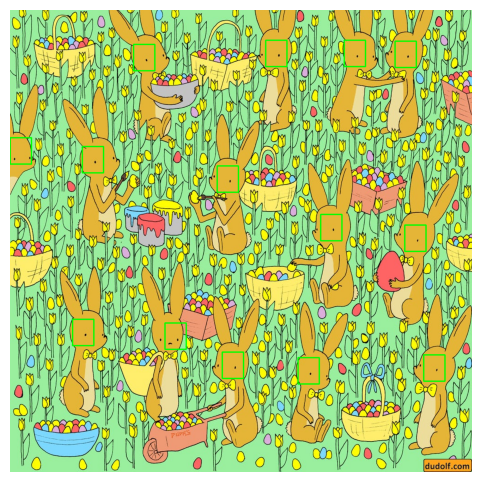

In [70]:
# Image loading and preprocessing
image = cv2.imread('/content/rabbit.jpeg')
image_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_edges = cv2.Canny(image_grey, 50, 150)


# Template matching
locations = [np.empty(0), np.empty(0)]
w, h = 46, 57  # Adjusted to better match the rabbit size in the image

x, y = 0, 276
image_grey, locations = process_match(image_grey, x, y, w, h, locations, down_threshold=1, up_threshold=1)

x, y = 448, 334
image_grey, locations = process_match(image_grey, x, y, w, h, locations, down_threshold=0.28, up_threshold=1)

# Apply Non-Maximum Suppression (NMS) to remove overlapping matches
def nms(boxes, w, h, overlap_threshold=0.4):
    if len(boxes) == 0:
        return []

    # Convert to list of [x, y, x+w, y+h]
    boxes = np.array([[pt[0], pt[1], pt[0] + w, pt[1] + h] for pt in boxes])
    pick = []

    # Get coordinates
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # Compute area of each box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlap_threshold)[0])))

    return [(int(boxes[i][0]), int(boxes[i][1])) for i in pick]

# Convert locations to a list of (x, y) coordinates
coords = list(zip(*locations[::-1]))
# Apply NMS
locations = nms(coords, w, h, overlap_threshold=0.4)

# # Optional: Apply additional filtering (e.g., keep coordinates where x > 100)
# def keep_coord(coord):
#     x, y = coord
#     return x > 100

# locations = list(filter(keep_coord, locations))
print('Số lượng thỏ:', len(locations))

# Draw rectangles on the original image
res_image = image.copy()
for pt in locations:
    pt = (int(pt[0]), int(pt[1]))
    cv2.rectangle(res_image, pt, (pt[0] + w, pt[1] + h), (0, 255, 0), 2)

# Show image
res_image = cv2.cvtColor(res_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.imshow(res_image)
plt.axis('off')
plt.show()

Số lượng chuột: 33585


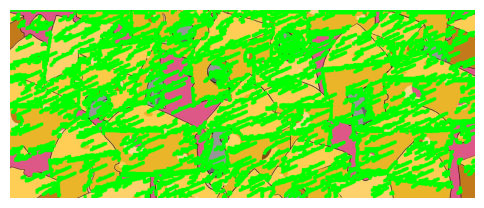

In [94]:
# Image loading and preprocessing
image = cv2.imread('/content/mouse.jpg')[144:]  # Crop the top part with text
image_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_edges = cv2.Canny(image_grey, 30, 100)  # Adjusted thresholds
hist = cv2.equalizeHist(image_grey)

locations = [np.empty(0), np.empty(0)]
w, h = 5, 5

x, y = 224, 260
imagex = image.copy()
hist, locations = process_match(hist, x, y, w, h, locations, down_threshold=0.65, up_threshold=1,
                                  resize_temp=True, min_scale_x=1, num_scales=5)

locations = list(zip(*locations[::-1]))
print('Số lượng chuột:', len(locations))

res_image = image.copy()
for pt in locations:
    pt = (int(pt[0]), int(pt[1]))
    cv2.rectangle(res_image, pt, (pt[0] + w, pt[1] + h), (0, 255, 0), 2)

# Show image
res_image = cv2.cvtColor(res_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.imshow(res_image)
plt.axis('off')
plt.show()